In [1]:
# vim: 
# author:
# date:
# content:

import numpy as np
import pandas as pd

In [2]:
def split(adata, columns, axis='obs'):
    '''Split AnnData by metadata column
    
    Args:
        adata (AnnData): The object to split
        columns (str or list): column(s) of metadata table to split by
        axis (str): 'obs' (default) or 'var'
        
    Returns:
        dict of AnnData with keys equal to the unique values found in that
        columns of the appropriate metadata (adata.obs or adata.var)
    '''
    if axis not in ('obs','var'):
        raise ValueError('axis must be "obs" or "var"')
    
    # getattr()用于返回一个对象属性值，eg.getattr(a, 'bar')获取a的‘bar’属性值
    meta = getattr(adata, axis)
    
    # isinstance() 函数来判断一个对象是否是一个已知的类型，类似type()
    if isinstance(columns, str):
        column = columns
        if column not in meta.columns:
            raise ValueError('column not found')
        metac = meta[column]
    else:
        if len(columns) < 1:
            return adata
        elif len(columns) == 1:
            return split(adata, columns[0], axis=axis)
        
        # Merge with @ (a hack, but alright in most cases)
        metac = meta[columns[0]].astype(str)
        for i, col in enumerate(columns[1:]):
            metac = metac + '@' + meta[col].astype(str)
            
    # Unique values
    metau = metac.unique()
    
    # Construct dict
    d = {}
    for key in metau:
        idx = metac.index[metac == key]
        if axis == 'obs':
            asub = adata[idx]
        else:
            asub = adata[:, idx]
    
        if not isinstance(columns, str) and (len(columns) > 1):
            key = key.split('@')
            for i, col in enumerate(columns):
                key[i] = type(meta[col].iloc[0])(key[i])
            key = tuple(key)

        d[key] = asub
    
    return d    

In [3]:
def average(adata, columns, axis='obs', log=False):
    '''Average expression by metadata column
    Args:
        adata (AnnData): The object to split
        columns (str or list): column(s) of metadata table to split by
        axis (str): 'obs' (default) or 'var'
        log (bool): If True, log (x + 0.1) counts before averaging and then
            exponentiate at the end
    Returns:
        pandas DataFrame with rows equal to the non-integrated axis names
        and columns equal to the keys of the AnnData split.
    '''
    adatad = split(adata, columns, axis=axis)

    if axis == 'var':
        iax = 1
        index = adata.obs_names
    else:
        iax = 0
        index = adata.var_names

    expd = {}
    for key, adatai in adatad.items():
        matrix = adatai.X
        if log:
            matrix = matrix.copy()
            matrix.data = np.log(matrix.data + 0.1)
        exp = np.asarray(matrix.mean(axis=iax))[0]
        if log:
            exp = np.exp(exp)
        expd[key] = exp
    expd = pd.DataFrame(expd, index=index)
    expd.name = 'Average expression'

    if isinstance(columns, str):
        expd.columns.name = columns
    else:
        expd.columns.names = columns

    return expd

In [4]:
def expressing_fractions(adata, columns, axis='obs', greater_than=0):
    '''Fraction of expressors by metadata column
    Args:
        adata (AnnData): The object to split
        columns (str or list): column(s) of metadata table to split by
        axis (str): 'obs' (default) or 'var'
        greater_than (float): only expressors stricly above this threshold are
          counted
    Returns:
        pandas DataFrame with rows equal to the non-integrated axis names
        and columns equal to the keys of the AnnData split.
    '''
    adatad = split(adata, columns, axis=axis)

    if axis == 'var':
        iax = 1
        index = adata.obs_names
    else:
        iax = 0
        index = adata.var_names

    fracd = {}
    for key, adatai in adatad.items():
        fr = np.asarray((adatai.X > greater_than).mean(axis=iax))[0]
        fracd[key] = fr
    fracd = pd.DataFrame(fracd, index=index)
    fracd.name = 'Fraction of expressing cells'

    if isinstance(columns, str):
        fracd.columns.name = columns
    else:
        fracd.columns.names = columns

    return fracd

Load interaction
Load high-quality cells only


/usr/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Trying to set attribute `.obs` of view, copying.


Restrict to interaction genes
Split by cell type, adult and child, and condition
Control interactions
Check average expression versus expressing fraction


/usr/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


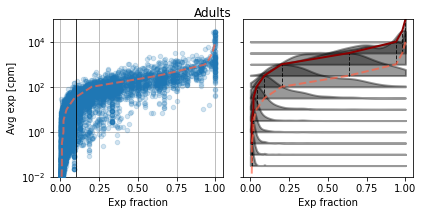

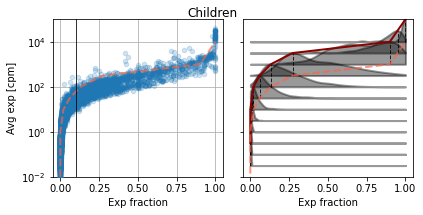

In [19]:
# average_expression
import os
import sys
import numpy as np
import pandas as pd

import anndata
import scanpy as sp

import matplotlib.pyplot as plt
import seaborn as sns

# sys.path.append('/home/yike/phd/function/')

pdict = {'child': [
    '1_019_01',
    '3_012_01',
    '3_037_01',
    '6_023_01',
    '3_047_01',
    '3_074_01',
    '5_030_01',
    '5_193_01',
    '5_154_01',
    '6_001_01',
    '5_041_01',
    '1_075_01',
    '1_140_01',
    '1_144_01',
    '5_044_01',
    '1_002_01',
    '6_020_01',
    '6_025_01',
    '6_028_01',
    '5_089_01'],
 'adult': [
     '3_013_01',
     '3_027_01',
     '1_008_01',
     '1_013_01',
     '1_020_01',
     '1_026_01',
     '3_018_01',
     '3_006_01',
     '1_010_01',
     '1_036_01'],
 }

def loc_gene_ct(fracd, gene, cell_type):
    return fracd.loc[gene, pd.IndexSlice[:, :, cell_type]] # 多层级DataFrame的取值fracd.loc[gene, (:, :, cell_type)]

if __name__ == '__main__':
    
    print('Load interaction')
    fn_int = '/home/yike/phd/dengue/data/interaction_unpacked_mouse.tsv'
    interactions = pd.read_csv(fn_int, sep='\t')[['gene_name_a', 'gene_name_b']]
    ga, gb = interactions['gene_name_a'], interactions['gene_name_b']
    
    if True:
        print('Load high-quality cells only')
        fn_h5ad = '/home/yike/phd/dengue/data/mergedata_20200930_high_quality.h5ad'
        adata = anndata.read_h5ad(fn_h5ad)
        adata.obs['dataset'] = adata.obs['platform'].replace({
            '10X': 'child',
            'plate': 'adult'   
        })
        adata.obs.rename(columns={'ID': 'Patient'}, inplace=True)
        sp.pp.normalize_total(adata, target_sum=1e6)
        
    print('Restrict to interaction genes')
    genes = np.unique(interactions)
    adatag = adata[:, genes]
    
    print('Split by cell type, adult and child, and condition')
    # from anndata_utils.partition import expressing_fractions
    obs = adatag.obs
    adatag.obs['split_col'] = obs['dataset'] + '+' + obs['Condition'].astype(str) + '+' + obs['cell_type'].astype(str)
    
    # split_cols = ['dataset', 'Condition', 'cell_type']
    
    fracd = expressing_fractions(adatag, ['dataset', 'Condition', 'cell_type'])
    avgd = average(adatag, ['dataset', 'Condition', 'cell_type'], log=False)
    stats = {
        'frac_exp': fracd,
        'avg_exp': avgd,
    }

    # Flexible criterion
    criterion = {'key': 'frac_exp', 'threshold': 0.1}
    criterion = {'key': 'avg_exp', 'threshold': {'child': 60, 'adult': 35}}

    from collections import defaultdict
    th = criterion['threshold']
    cell_types = list(obs['cell_type'].cat.categories)
    res = []
    for col in fracd.columns:
        datas, cond, cell_type1 = col
        for cell_type2 in cell_types:
            col2 = (datas, cond, cell_type2)
            fra = fracd.loc[ga, col].values
            frb = fracd.loc[gb, col2].values
            avga = avgd.loc[ga, col].values
            avgb = avgd.loc[gb, col2].values
            key = criterion['key']
            if isinstance(th, dict):
                th1 = th[col[0]]
            else:
                th1 = th

            ind = (stats[key].loc[ga, col].values > th1) & (stats[key].loc[gb, col2].values > th1)
            ind = ind.nonzero()[0]
            for i in ind:
                resi = {
                    'dataset': datas,
                    'Condition': cond,
                    'cell_type1': cell_type1,
                    'cell_type2': cell_type2,
                    'gene_name_a': interactions.iloc[i]['gene_name_a'],
                    'gene_name_b': interactions.iloc[i]['gene_name_b'],
                    'frac1': fra[i],
                    'frac2': frb[i],
                    'avg1': avga[i],
                    'avg2': avgb[i],
                }
                res.append(resi)
    res = pd.DataFrame(res)

    res['frac_sum'] = res['frac1'] + res['frac2']
        
    # Make it redundant
    res2 =res.loc[res['cell_type1'] != res['cell_type2']].copy()
    res2.rename(columns={
        'cell_type1': 'cell_type2',
        'cell_type2': 'cell_type1',
        'gene_name_a': 'gene_name_b',
        'gene_name_b': 'gene_name_a',
        'frac1': 'frac2',
        'frac2': 'frac1',
        'avg1': 'avg2',
        'avg2': 'avg1',
    }, inplace=True)
    res2 = res2[res.columns]

    resr = pd.concat([res, res2], axis=0)

    print('Control interactions')
    known_interactions = [
        ['B_cells', 'CD40', 'T_cells', 'CD40LG'],
    ]
    known_interactions = pd.DataFrame(
        known_interactions,
        columns = ['cell_type1', 'gene_name_a', 'cell_type2', 'gene_name_b'],
    )

    ubi_interactions = [
        ['SELL', 'SELPLG'],
        ['CD22', 'PTPRC'],
        ['CD55', 'ADGRE5'],
        ['ICAM2', 'ITGAL'],
        ['ICAM2', 'ITGB2'],
    ]
    
    ubi_interactions = pd.DataFrame(
            ubi_interactions,
            columns=['gene_name_a', 'gene_name_b'],
            )
    genes_ubi = []
    for pair in ubi_interactions.values:
        for gene in pair:
            if gene not in genes_ubi:
                genes_ubi.append(gene)

    if False:
        print('Dot plot')
        adatad1 = split(adata, ['dataset', 'Condition'])
        fig, axs = plt.subplots(2, 1, figsize=(6,6))
        plurals = {'adult': 'adults', 'child': 'children'}
        for ax, key in zip(axs, ['adult', 'child']):
            sc.pl.dotplot(
                adatad1[(key, 'Healthy')],
                var_names=genes_ubi,
                groupby='cell_type',
                ax=ax,
                log=True,
                title=plurals[key].capitalize(),
            )
        fig.tight_layout()

    avgdp = average(adata, ['Patient', 'Condition', 'cell_type'], log=True)

    def plot_genes(avgd, cell_type, ax=None, cond='Healthy', genes=genes_ubi, **kwargs):
        # the average expression of genes in all patients at different conditions and cell_types
        df = avgd.loc[genes, pd.IndexSlide[:, cond, cell_type]] # eg: ave_expre.loc[['COPA', 'SELL'], ('adult', 'Healthy', 'T_cells')]
        if ax is None:
            fig, ax = plt.subplots()
        else:
            fig = None

        kwargs['marker'] = kwargs.get('marker', 'o')
        kwargs['alpha'] = kwargs.get('alpha', 0.7) # alpha： transparency
        df.plot(
            lw=2,
            ax=ax,
            xticks=np.arange(df.shape[0]), #subtick of x axis 
            rot=90, #旋转刻度标签
            **kwargs
        )
        ax.set_yscale('log') # log y axis
        ax.grid(True)
        ax.set_ylabel('Avg exp [cpm]')
        ax.set_title(cell_type.replace('_', ' '))
        if fig is not None:
            fig.tight_layout()
        return {'fig': fig, 'ax': ax}

    def plot_adult_child(avgdp, cell_type, genes=genes_ubi, ax=None, **kwargs):
        avgd1 = avgdp[np.unique(
            [x for x in avgdp.columns.get_level_values(0) if x in pdict['adult']], # eg: avgdp.columns -->('5_044_01','dengue','B_cells')
            )]
        avgd2 = avgdp[np.unique(
            [x for x in avgdp.columns.get_level_values(0) if x in pdict['child']],
            )]
        d = plot_genes(avgd1, cell_type, genes=genes, marker='s', ax=ax, **kwargs)
        d = plot_genes(avgd2, cell_type, genes=genes, marker='o', ax=d['ax'], **kwargs)
        return d

    def plot_adult_child_all(avgdp, genes=genes_ubi, **kwargs):
        fig, axs = plt.subplots(2, 2, figsize=(8, 6), sharex=True)
        axs = axs.ravel() # transfer multi-dimensional DataFrame to one-dimensional DataFrame
        cell_types = ['B_cells', 'T_cells', 'NK_cells', 'Monocytes']
        for ax, cell_type in zip(axs, cell_types):
            plot_adult_child(avgdp, cell_type, genes=genes, ax=ax, **kwargs)
            ax.legend([])
        fig.tight_layout()
        return{'fig': fig, 'axs': axs}

    if False:
        print('Example: B cells')
        plot_genes(avgd, 'B_cells')

    print('Check average expression versus expressing fraction')
    df = pd.concat([
        avgd.loc[genes].stack([0,1,2]),
        fracd.stack([0,1,2])],
        axis=1) # concat on row level
    df.columns = ['Avg exp [cpm]', 'Exp fraction']

    def plot_correspondence(df):
        fig, axs = plt.subplots(1, 2, figsize=(6, 3), sharex=True, sharey=True)
        df.plot.scatter(
                x='Exp fraction', y='Avg exp [cpm]',
                ax=axs[0],
                alpha=0.2,
                zorder=10,
                )
        from scipy.stats import gaussian_kde
        ybins = [[-2, -1],
                 [-1.5, -0.5],
                 [-1, 0],
                 [-0.5, 0.5],
                 [0, 1],
                 [0.5, 1.5],
                 [1, 2],
                 [1.5, 2.5],
                 [2, 3],
                 [2.5, 3.5],
                 [3, 4],
                 [3.5, 4.5],
                 ]
        ybins = np.array(ybins)
        ytobin = np.log10(df['Avg exp [cpm]'])
        ridge = []
        base = [[0, 1e-5]]
        xfit = np.linspace(0, 1, 100)
        for bl, br in ybins:
            bc = 0.5 * (bl + br)
            tmp = df.loc[(ytobin >= bl) & (ytobin < br)]
            xtmp = tmp['Exp fraction'].values
            if len(xtmp) > 2:
                yfit = gaussian_kde(xtmp, bw_method=0.3)(xfit)
            else:
                yfit = np.zeros_like(xfit)
            if len(xtmp) == 1:
                i = np.argmin(np.abs(xfit - xtmp[0]))
                yfit[i] = 1
            if len(xtmp):
                yfit *= 1 / yfit.max()
            ytmp = 10**(bc + yfit)
            imax = np.argmax(ytmp)
            ridge.append([xfit[imax], ytmp[imax]])
            base.append([xfit[imax], 10**bc])
            axs[1].fill_between(xfit, 10**bc, ytmp, lw=2, color='k', alpha=0.4)
            axs[1].plot(
                    [base[-1][0]] * 2, [base[-1][1], ridge[-1][1]], lw=1,
                    color='k', alpha=0.8, ls='--')
        ridge = np.array(ridge)
        base = np.array(base)

        # Model as x = f(y), because the average exp is what we really have
        from scipy.interpolate import interp1d
        model = interp1d(np.log10(base[:, 1]), base[:, 0],
                kind='linear')

        def logmodel(y):
            '''Get the fraction of expressing from the avg exp [cpm]'''
            return model(np.log10(y))

        model_inverse = interp1d(base[:, 0], np.log10(base[:, 1]))

        def logmodel_inverse(x):
            '''Get the avg exp [cpm] from the fraction of expressing'''
            return 10**model_inverse(x)

        ymodel = np.logspace(-2, 4, 100)

        axs[1].plot(ridge[:, 0], ridge[:, 1], lw=2, color='darkred')
        axs[1].plot(base[:, 0], base[:, 1], lw=2, color='tomato', ls='--', alpha=0.7)
        axs[0].plot(logmodel(ymodel), ymodel, lw=2, color='tomato', ls='--', zorder=11, alpha=0.7)
        axs[0].axvline(0.1, lw=1, color='k', alpha=0.8, zorder=11)
        axs[1].set_xlabel(axs[0].get_xlabel())
        axs[0].set_ylim(bottom=0.01)
        axs[0].set_yscale('log')
        axs[0].grid(True)
        fig.tight_layout()

        base = pd.DataFrame(
            base,
            columns=['Exp fraction', 'Avg exp [cpm]'],
            )

        return {
            'fig': fig, 'axs': axs,
            'base': base, 'model': logmodel, 'model_inverse': logmodel_inverse,
            }

    dadults = plot_correspondence(df.loc[pd.IndexSlice[:, 'adult'], :])
    dadults['fig'].suptitle('Adults')
    dchildren = plot_correspondence(df.loc[pd.IndexSlice[:, 'child'], :])
    dchildren['fig'].suptitle('Children')

    if False:
        fig_fdn = '../../figures/equipotential/'
        dadults['fig'].savefig(f'{fig_fdn}kde_adults.png')
        dchildren['fig'].savefig(f'{fig_fdn}kde_children.png')

        print('Match the two models')
        tmodel = np.linspace(0, 1, 100)
        exp_adults = dadults['model_inverse'](tmodel)
        exp_children = dchildren['model_inverse'](tmodel)

        fig, ax = plt.subplots(figsize=(3.2, 3))
        ax.plot(exp_adults, exp_children, '-', lw=2, color='darkred')
        xx = np.logspace(-1, 4, 100)
        ax.plot(xx, xx, lw=2, color='k', alpha=0.7, ls='--')
        ax.plot(xx, 1.6*xx, lw=2, color='grey', alpha=0.7, ls='--')
        ax.set_xlim(1e-1, 1e4)
        ax.set_ylim(1e-1, 1e4)
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.grid(True)
        ax.set_xlabel('Avg exp adults [cpm]')
        ax.set_ylabel('Avg exp children [cpm]')
        ax.set_title('Equipotential line\n(fraction expressing)')
        fig.tight_layout()
        fig.savefig(f'{fig_fdn}equivalence.png')

    plt.ion(); plt.show()

In [20]:
resr.to_excel('/home/yike/phd/dengue/data/excels/average(60_35)&fraction(0.1).xls', index=False)